# Comparison between different analysis

Import the pre-generated dataset.

In [1]:
import scipy as sp

dataset = sp.io.loadmat("data/SwissRoll_example_separated_4000.mat")
print(dataset.keys())
data3 = dataset["data3"]
Lbl = dataset["Lbl"]
print(data3.shape)
print(Lbl.shape)


dict_keys(['__header__', '__version__', '__globals__', 'Eiso', 'Klle', 'Lbl', 'NNumap', 'Perp', 'Sz', 'Yiso', 'Ylle', 'Ymds', 'Ysne', 'Yumap', 'centers', 'data3'])
(4000, 3)
(1, 4000)


Build the labels which will be useful for data visualization and build distance matrix

In [2]:
Ngrp = 1000
Nlbl = 4
i1 = 1
i2 = Ngrp
for ind in range(Nlbl):
    Lbl[i1:i2] = ind
    i1 += Ngrp
    i2 += Ngrp


Visualize data in 3D figure

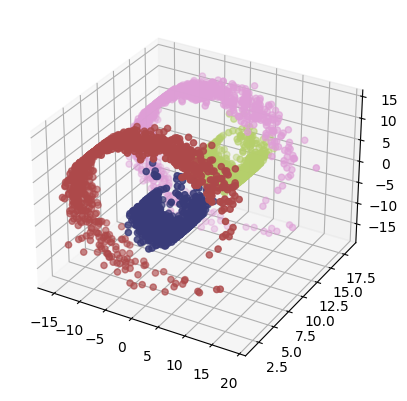

In [3]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter3D(data3[:, 0], data3[:, 1], data3[:, 2], c=Lbl, cmap="tab20b")


## PCA analysis

We are now on a non-linear manifold. How will a linear analysis like PCA perform?

Actually, not so well.
We can see that the groups are overlapped.

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=data3.shape[1])
pca.fit(data3)

Score = pca.transform(data3)


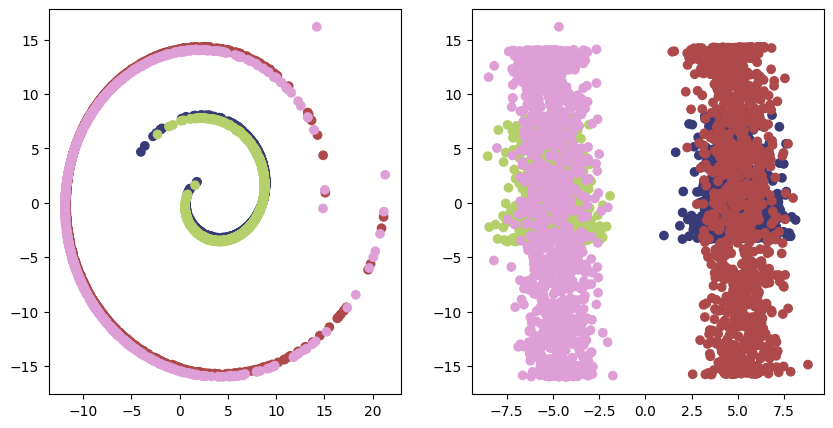

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].scatter(Score[:, 0], Score[:, 1], c=Lbl, cmap="tab20b")
ax[1].scatter(Score[:, 2], Score[:, 1], c=Lbl, cmap="tab20b")


## Classical MDS

MDS uses the same concept of PCA, the only difference is that now are the euclidean distances to be minimized.
We don't expect much different results with respect to PCA.

In [6]:
from sklearn.manifold import MDS

mds = MDS(
    n_components=data3.shape[1], dissimilarity="euclidean", normalized_stress=False
)
Ymds = mds.fit_transform(data3)


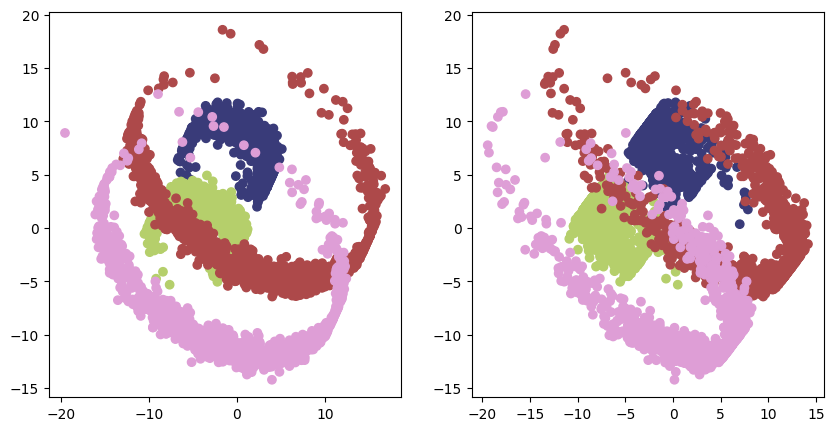

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].scatter(Ymds[:, 0], Ymds[:, 1], c=Lbl, cmap="tab20b")
ax[1].scatter(Ymds[:, 2], Ymds[:, 1], c=Lbl, cmap="tab20b")


## LLE - Local Linear Embedding

Another technique we can try to apply is the locally linear embedding, which strongly depends on the number of neighbors.
This method relies on a local convexity assumption.

Here we actually have a nice result with 70 neighbors while the other two result too small and high, respectively.

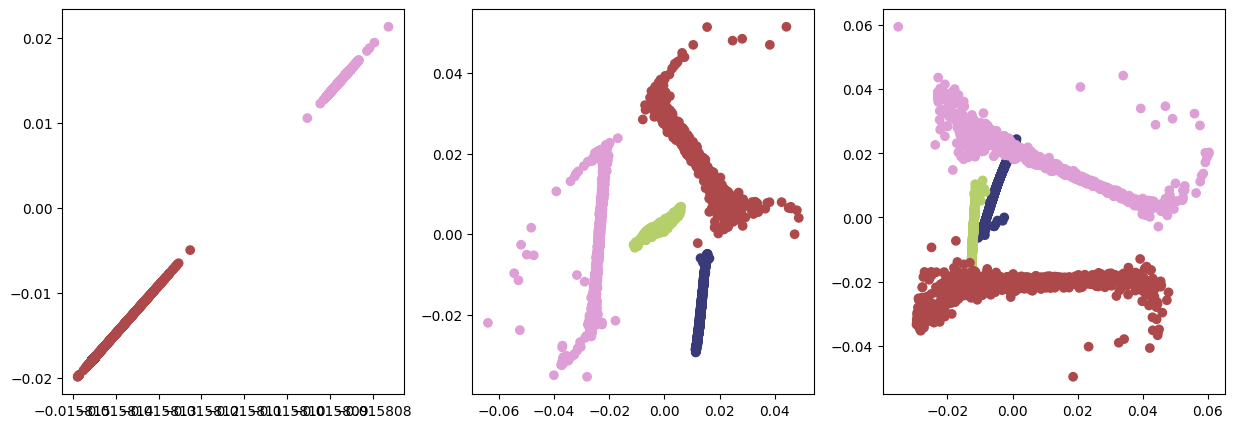

In [8]:
from sklearn.manifold import LocallyLinearEmbedding as LLE

Klle = [20, 70, 120]
DimEmb = 2

fig, ax = plt.subplots(ncols=len(Klle), figsize=(len(Klle) * 5, 5))

for ind, neigh in enumerate(Klle):
    lle = LLE(n_components=DimEmb, n_neighbors=neigh, method="standard")
    Ylle = lle.fit_transform(data3)
    ax[ind].scatter(Ylle[:, 0], Ylle[:, 1], c=Lbl, cmap="tab20b")


## ISOMAP

Approach based on network theory, which identifies the geodesics of the initial variable space then apply geodetic-based distances.

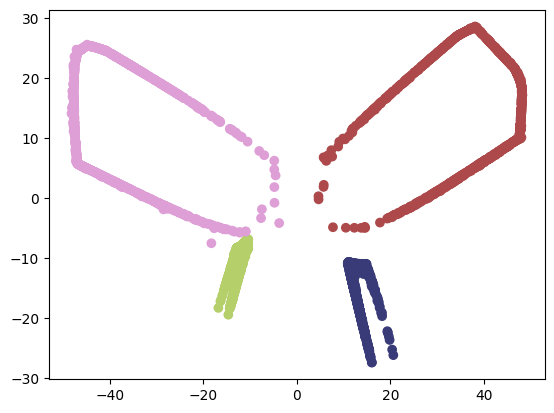

In [9]:
Sz = 15  # number of neighbors per distance. Below 5 we've a disconnected component

from sklearn.manifold import Isomap

isomap = Isomap(n_neighbors=Sz, p=2, neighbors_algorithm="auto")
Yiso = isomap.fit_transform(data3)

plt.scatter(Yiso[:, 0], Yiso[:, 1], c=Lbl, cmap="tab20b")


## tSNE

The main goal is to reproduce a proximity measure defined in the sample space on a lower-dimensional space.
Hypothesis: the neighborhood of each sample point follow a gaussian distribution.
To maximize the similarity between the two different spaces this algorithm uses the *Kullback-Leiber* divergence, minimizing a cost function through a gradient descent method.

**NOTE**: gradient corresponds to a set of elastic forces in the new space with variable stiffness given by difference between distributions.
The t-variant of this algorithm we're using means that heavier tails (i.e. Cauchy distributed) are allowed in the new space.

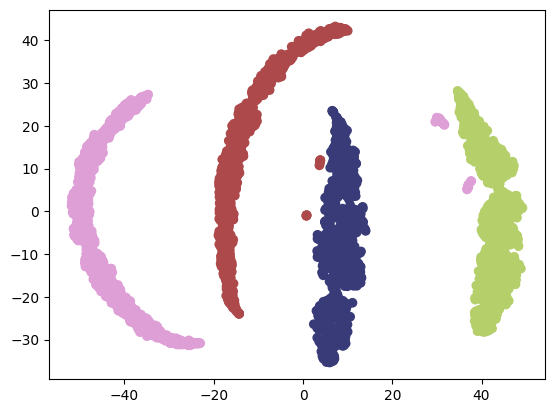

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=80)  # default perplexity=30
Ysne = tsne.fit_transform(data3)

plt.scatter(Ysne[:, 0], Ysne[:, 1], c=Lbl, cmap="tab20b")


## UMAP

UMAP is a K-neighbor graph-based algorithm (an evolution of ISOMAP and tSNE).
It identifies the k neighbors of each node, then builds a weighted directed graph.
By symmetrizing this graph using point wise Hadamard product, so symmetric links are not counted twice, one can use the resulting matrix for spring-embedding layout.

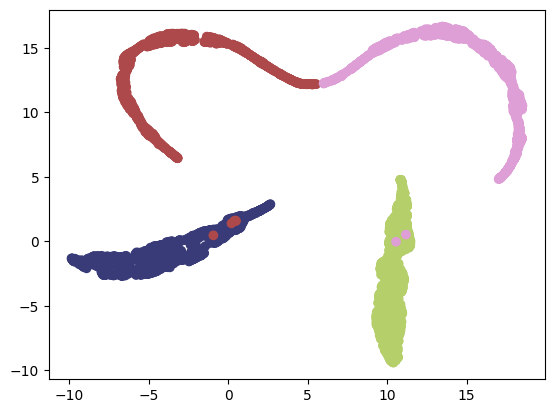

In [11]:
from umap import UMAP

umap = UMAP(n_neighbors=30)  # default n_neighbors=15
Uxy = umap.fit_transform(data3)

plt.scatter(Uxy[:, 0], Uxy[:, 1], c=Lbl, cmap="tab20b")
